# Seguir un procesos de vacunación en los recintos electorales que se describe a continuación:
* Solo se va a tener en cuenta uno de los recintos electorales.
* Se tomaran los resultados de la regresión para la vacuna según la llegada.
* Se tiene una promedio que el 80% de personas realizaran el proceso de vacunación dentro del Ecuador.
*	Dentro del procesos se tiene que alrededor del 5% - 10% no podrán vacunarse.
*	Las personas solo tiene un recinto electoral para realizar el proceso.
*	Las personas realizan la primera vacuna y 30 días después la segunda vacuna.
*	La persona se acerca a la mesa  y hacen fila en caso de ser necesario para recibir la vacuna.
*	Realiza la vacunación en un tiempo aleatorio entre 5 a 10 minutos.
*	Debe esperar 20 minutos dentro del establecimiento para verificar que no tenga problemas de salud.
*	La persona recibe su certificado de vacunación y la fecha de la próxima vacuna entre 2 – 3 minutos.
*	La persona sale del recinto electoral.
*	Regresan para la próxima fecha y se repite el ciclo.

Deben calcularse las siguientes métricas:
*	Total de de personas que realizaron el proceso de vacunación.
*	Grafico del porcentaje de personas que no recibieron la vacuna.
*	El tiempo promedio de espera.


ANALISIS DEL ESCENARIO

## En el sector de Totoracocha (mi lugar de votacion) segun los datos obtenidos por el CNE http://portal.cne.gob.ec/documents/Estadisticas/cne_registro_electoral.pdf en la seccion resumen por canton y parroquia, se obtuvo:

*   numero electores = 21.778 
*   numero de juntas = 70
*   numero de recintos = 3

Con lo que se puede decir que en mi sector Totoracocha dentro de mi recinto, acudieron a votar aproximadamente 7259 personas.

Segun datos del misiterio de salud https://www.salud.gob.ec/ecuador-18-millones-de-vacunas-negociadas-para-el-2021-2/ se negociaron un total de 18 millones de vacunas para lo que resta del año. Si este numero de vacunas los dividimos para el numero de provinvias que son 24, tendriamos un total de 750.00 vacunas por provincia. A esto segun datos de El Comercio https://www.elcomercio.com/actualidad/politica/elecciones-cne-recintos-electorales-coronavirus.html para las elecciones del 2021 hubieron 4276 recintos electorales dando un promedio de 178 recintos por provincia. Finalmente si dividimos las 750.000 vacunas para el numero de recintos promedio por provincia (178) nos dara como resultado de que aproximadamente cada recinto contara con 4213 vacunas. 

# Enunciado
En base a la practica de covid de vacunacion, realizar el proceso de interrupcion en base a que el 5% de los pacientes que estan en la sala de espera presentan complicaciones de salud y deben ser trasladados inmediatamente al centro de salud mas cercano y ser atendidos. Realizar este proceso y generar una segunda linea de simulacion para el traslado, atencion y alta del paciente que presenta complicaciones, en base a los siguientes datos:

* Traslado de ambulancia: 5 - 15 minutos
* Atencion centro de salud: 5 - 24 horas
* Alta: 1 - 2 horas
* El 10% de las personas que presentan complicaciones fallecen

Generar graficas que indiquen las personas que presentaron complicaciones en base a los tiempos, estado e las personas y respuesta

### Definimos nuestras variables globales

In [251]:
import simpy
import random
import matplotlib.pyplot as pp
import math

# Numero de vacunas en el recinto electoral
NUM_VACUNAS = 70 #4213

# Del numero de personas a vacunarse en el recinto solo el 80% lo hara
NUM_PERSONAS_RECINTO = 150#(7259 * 80) / 100

# Numero de personas que se encargan de la vacunacion (5-6)
NUM_PERSONAL = 6

# Numero de personas llamadas a la vacunacion
NUM_PERSONAS_VACUNACION = NUM_PERSONAS_RECINTO

# Tiempo proceso de control (2-5 minutos)
PROCESO_CONTROL = 2

# Representa el numero de personas que no seran vacunadas
# Solo del 5% al 10% no pasa el control y no se vacuna
# Para ello obtenemos el numero de personas que representa el un valor de entre el 5 y 10%
PORCENTAJE = 7
NO_VACUNADAS = (NUM_PERSONAS_VACUNACION * PORCENTAJE) / 100

# Tiempo traslado persona hacia silla o camilla (5-10 minutos)
TRASLADO_CAMILLA = 5

# Tiempo que se demora en vacunar (3 a 5 minutos)
TIEMPO_VACUNACION = 4

# Tiempo espera luego de la vacunacion (22 - 23 minutos)
TIEMPO_ESPERA_VACUNACION = 22

# Tiempo espera luego de la vacunacion para la segunda dosis
TIEMPO_ESPERA_SEGUNDA_DOSIS = 100

# Tiempo de simulación
TIEMPO_SIMULACION = 8000#50000

# Intervalo de tiempo en que llegan las personas (minutos)
INTERVALO_LLEGADA = 5

#------------------------------------------------------------------------------------------------------------------

# Representa el porcentaje de personas que tienen complicaciones luego de recibir su vacuna
PORCENTAJE_COMPLICACIONES = (NUM_PERSONAS_VACUNACION * 5) / 100

# Tiempo en que se demora la ambulancia en trasladar al paciente
TIEMPO_AMBULANCIA = 10

# Tiempo en minutos permanecer en el centro de salud
TIEMPO_CENTRO_SALUD = 360 # 6 horas

TIEMPO_ALTA = 60 # 1 hora

PORCENTAJE_FALLECEN = (NUM_PERSONAS_VACUNACION * 10) / 100

#------------------------------------------------------------------------------------------------------------------

# Creamos un diccionario para almacenar la persona y el tiempo de espera antes de presentar complicaciones
tiempo_espera_complicaciones = {}

# Creamos un diccionario para almacenar las personas que presentaron complicaciones
complicaciones = {}

# Creamos un diccionario para almacenar las personas que fueron dadas de alta
de_alta = {}

# Creamos un diccionario para almacenar las personas fallecidas
fallecidas = {}

#------------------------------------------------------------------------------------------------------------------

# Creamos un diccionario para almacenar la persona y el tiempo de espera antes de pasar al control
tiempo_espera = {}

# Creamos un diccionario para almacenar la persona y el tiempo total que toma vacunarse
tiempo_total_vacunacion = {}

# Creamos un diccionario para almacenar las personas vacunadas
vacunados = {}

# Creamos un diccionario para almacenar las personas no vacunadas
no_vacunados = {}

# Creamos un diccionario para almacenar las personas y sus estados
# ya sean: en espera, en control, en traslado y vacunada.
personas = {}

## Creamos nuestra clase vacunacion la cual tendra las funciones de vacunar, de proceso de control y de trasladar.

In [252]:
class Vacunacion(object):
    
    def __init__(self, environment, num_personal, tiempo_vacunacion, traslado_camilla, tiempo_espera, persona):
        # Guardamos como variable el entorno de ejecucion
        self.env=environment
        # Creamos el recurso que representa las maquinas
        self.personal = simpy.Resource(environment, num_personal)
        # Variable para el tiempo de vacunacion
        self.tiempo_vacunacion = tiempo_vacunacion
        # Variable para el tiempo de traslado
        self.traslado_camilla = traslado_camilla
        # Variable para el tiempo de espera antes de salir
        self.tiempo_espera = tiempo_espera
        self.proceso_esperar = env.process(self.espera_persona(persona))

        
    def vacunar_persona(self, persona):
        yield self.env.timeout(random.randint(TIEMPO_VACUNACION-1, TIEMPO_VACUNACION+1))
        # Guardamos a la persona con estado "Vacunada"
        personas[persona] = "Vacunada"
        # Si se ha vacunado guardamos a la persona con su tiempo
        tiempo_total_vacunacion[persona] = env.now
        
    def trasladar_persona(self, persona):
        yield self.env.timeout(TRASLADO_CAMILLA)
        # Guardamos a la persona con estado "Traslado"
        personas[persona] = "Traslado"
        
    def espera_persona(self, persona):
        try:
            yield self.env.timeout(TIEMPO_ESPERA_VACUNACION)
            # Guardamos a la persona con estado "VacunadaEspera"
            personas[persona] = "VacunadaEspera"
        except simpy.Interrupt:
            print('**^^ CON COMPLICACIONES %s ' % (persona))
            yield self.env.timeout(TIEMPO_AMBULANCIA)
            yield self.env.timeout(TIEMPO_CENTRO_SALUD)
            yield self.env.timeout(TIEMPO_ALTA)
            
    def atender_persona_centro(self, persona):
        yield self.env.timeout(TIEMPO_CENTRO_SALUD)
        
   
    def espera_segunda_dosis(self, persona):
        yield self.env.timeout(TIEMPO_ESPERA_SEGUNDA_DOSIS)
        # Guardamos a la persona con estado "VacunadaEsperaSegunda"
        personas[persona] = "VacunadaEsperaSegunda"
        
    def proceso_control(self, persona):
        yield self.env.timeout(PROCESO_CONTROL)
        # Guardamos a la persona con estado "Control"
        personas[persona] = "Control"
        # Guardamos a la persona con el tiempo
        # Esto no permite saber cuando tuvo que esperar una persona para ser atendida
        tiempo_espera[persona] = env.now
        
def segunda_dosis(env, nombre, vacunacion):
    # Se traslada a su segunda dosis
    print('↔ Se traslada %s 2da dosis a la hora %.2f.' % (nombre,env.now))
    # Procesamos el traslado de la persona a su segunda dosis
    yield env.process(vacunacion.trasladar_persona(nombre))
    # Indicamos que la persona entra a vacunarse a su segunda dosis
    print('→ Entra %s a vacunarse 2da dosis a la hora %.2f.' % (nombre, env.now))
                    
    # Verificamos que hayan vacunas disponible
    if(len(vacunados.keys())<NUM_VACUNAS-1):
        # Procesamos la operacion de vacunacion
        yield env.process(vacunacion.vacunar_persona(nombre))
        # Una vez que termina la llamada con 'yield', se indica que se ha vacunado la persona
        print('✓✓ [%s] vacunada 2da dosis a las %.2f.' % (nombre, env.now))  
        # Guardamos el nombre de la persona vacunada y el tiempo en que le tomo vacunarse
        vacunados[nombre]=env.now
        print('%s 2da dosis procede a esperar antes de salir a la hora %.2f.' % (nombre, env.now))
    else:
        print('xx Se han acabado las vacunas xx')
    
       
    
def llegada_persona(env, nombre, vacunacion):
    # Usamos el reloj de la simulacion (env.now()) para indicar a la
    # hora que llega la con el nombre pasado como parametro
    print('Llega %s a la hora %.2f.' % (nombre, env.now))
    # Ponemos como estado "Espera" a la persona
    personas[nombre] = "Espera"
    
    # Especificamos que vamos a usar un recurso (Resource) que representa
    # la estacion de vacunacion
    with vacunacion.personal.request() as personal:
        # Ocupamos el area del personal
        yield personal
        # Entra al proceso de control
        yield env.process(vacunacion.proceso_control(nombre))
    
        # Verificamos que el numero de personas no vacunadas
        # no exceda al % de personas que no son vacunadas 
        # segun el numero de personas que asisten a vacunarse
        if(len(no_vacunados.keys())<=(int(math.floor(NO_VACUNADAS)))):  

            # Generamos un numero randomico entre 1 y 20 que representa el 5%
            # y que sea menor o igual a 5. 
            # Realizamos esto para darle mas aleatoriedad al modelo
            if((random.randint(1,22))<=PORCENTAJE):
                # Si se cumplen las condiciones (no pasa el control) lo guardamos en no vacunados
                no_vacunados[nombre]=env.now
                print('** [%s] no ha pasado el control**' % (nombre))
                print('** [%s] no ha sido vacunada**' % (nombre)) 
            else:
                # Si pasa el control se procede a su traslado 
                print('[%s] a pasado el control' % (nombre)) 
                #Indicamos que la persona se esta trasladando para ser vacunada
                print('↔ Se traslada %s a la hora %.2f.' % (nombre,env.now))
                #Procesamos el traslado de la persona
                yield env.process(vacunacion.trasladar_persona(nombre))
                # Indicamos que la persona entra a vacunarse
                print('→ Entra %s a vacunarse a la hora %.2f.' % (nombre, env.now))
                
                # Verificamos que hayan vacunas disponible
                if(len(vacunados.keys())<NUM_VACUNAS-1):
                    # Procesamos la operacion de vacunacion
                    yield env.process(vacunacion.vacunar_persona(nombre))
                    # Una vez que termina la llamada con 'yield', se indica que se ha vacunado la persona
                    print('✓✓ [%s] vacunada a las %.2f.' % (nombre, env.now))  
                    # Guardamos el nombre de la persona vacunada y el tiempo en que le tomo vacunarse
                    vacunados[nombre]=env.now
                    tiempo_espera_complicaciones = env.now
                    print('%s procede a esperar antes de salir a la hora %.2f.' % (nombre, env.now))
                    
                    ################################ COMPLICACIONES #############################
                    
                    # Verificamos que no se supere el porcentaje de personas con complicaciones
                    if(len(complicaciones.keys())<=(int(math.floor(PORCENTAJE_COMPLICACIONES)))):
                        if((random.randint(1,22))<=5):
                            # Obtenemos el tiempo que se demoro en obtener complicaciones
                            tiempo_espera_complicaciones=env.now-tiempo_espera_complicaciones
                            vacunacion.proceso_esperar.interrupt(nombre)
                            print('*+* [%s] Ha presentado complicaciones se la trasladara en ambulancia para atenderla en un centro de salud' % (nombre))
                        
                            complicaciones[nombre] = env.now
                            
                            # Verificamos que no se supere el porcentaje de fallecimiento
                            if(len(fallecidas.keys())<=(int(math.floor(PORCENTAJE_FALLECEN)))):
                                if((random.randint(1,12))<=3):
                                    fallecidas[nombre]=env.now
                                    print('††† [%s] Ha fallecido †††' % (nombre))
                                else:
                                    de_alta[nombre]=env.now
                                    print('☺☺☺ [%s] Ha sido dada de alta ☺☺☺' % (nombre))
                            else:
                                de_alta[nombre]=env.now
                                print('☺☺☺ [%s] Ha sido dada de alta ☺☺☺' % (nombre))
                        else:
                            yield env.process(vacunacion.espera_persona(nombre))
                            env.process(segunda_dosis(env, nombre ,vacunacion))
                    else:
                        yield env.process(vacunacion.espera_persona(nombre))
                        env.process(segunda_dosis(env, nombre ,vacunacion))
                else:
                    print('xx Se han acabado las vacunas xx')
        else:
            # Si pasa el control se procede a su traslado 
            print('[%s] a pasado el control' % (nombre)) 
            #Indicamos que la persona se esta trasladando para ser vacunada
            print('↔ Se traslada %s a la hora %.2f.' % (nombre,env.now))
            #Procesamos el traslado de la persona
            yield env.process(vacunacion.trasladar_persona(nombre))
            # Indicamos que la persona entra a vacunarse
            print('→ Entra %s a vacunarse a la hora %.2f.' % (nombre, env.now))
            if(len(vacunados.keys())<NUM_VACUNAS-1):
                # Procesamos la operacion de vacunacion
                yield env.process(vacunacion.vacunar_persona(nombre))
                # Una vez que termina la llamada con 'yield', se indica que se ha vacunado la persona
                print('✓✓ [%s] vacunada a las %.2f.' % (nombre, env.now))  
                # Guardamos el nombre de la persona vacunada y el tiempo en que le tomo vacunarse
                vacunados[nombre]=env.now
                print('%s procede a esperar antes de salir a la hora %.2f.' % (nombre, env.now))
                
                ################################ COMPLICACIONES #############################
                    
               # Verificamos que no se supere el porcentaje de personas con complicaciones
                if(len(complicaciones.keys())<=(int(math.floor(PORCENTAJE_COMPLICACIONES)))):
                    if((random.randint(1,22))<=5):
                        # Obtenemos el tiempo que se demoro en obtener complicaciones
                        tiempo_espera_complicaciones=env.now-tiempo_espera_complicaciones
                        vacunacion.proceso_esperar.interrupt(nombre)
                        print('*+* [%s] Ha presentado complicaciones se la trasladara en ambulancia para atenderla en un centro de salud' % (nombre))
                        
                        complicaciones[nombre] = env.now
                            
                        # Verificamos que no se supere el porcentaje de fallecimiento
                        if(len(fallecidas.keys())<=(int(math.floor(PORCENTAJE_FALLECEN)))):
                            if((random.randint(1,12))<=3):
                                fallecidas[nombre]=env.now
                                print('††† [%s] Ha fallecido †††' % (nombre))
                            else:
                                de_alta[nombre]=env.now
                                print('☺☺☺ [%s] Ha sido dada de alta ☺☺☺' % (nombre))
                        else:
                            de_alta[nombre]=env.now
                            print('☺☺☺ [%s] Ha sido dada de alta ☺☺☺' % (nombre))
                    else:
                        yield env.process(vacunacion.espera_persona(nombre))
                        env.process(segunda_dosis(env, nombre ,vacunacion))
                else:
                    yield env.process(vacunacion.espera_persona(nombre))
                    env.process(segunda_dosis(env, nombre ,vacunacion))
            else:
                print('xx Se han acabado las vacunas xx')
                
        
def ejecutar_simulacion(env, num_personal, num_vacunas, tiempo_vacunacion, traslado_camilla, tiempo_espera, intervalo):
    vacunacion=Vacunacion(env, num_personal, tiempo_vacunacion, traslado_camilla, tiempo_espera, 1)
    # Creamos 5 llegadas de personas iniciales
    for i in range(2,5):
        env.process(llegada_persona(env, 'Persona-%d'%(i+1),vacunacion))
        
    # Ejecutamos la simulacion
    band=True
    while band==True:
        yield env.timeout(random.randint(intervalo-2, intervalo+2))
        i+=1
        # Mientras se vacunan las personas llegan mas
        if(len(vacunados.keys())<(NUM_VACUNAS-2)):
            env.process(llegada_persona(env,'Persona-%d'%(i+1),vacunacion))
        else:
            band=False

## Ejecutamos la simulacion y calculamos el numero de personas atendidas, el numero de personas no atendidas, el numero de personas vacunadas y el numero de personas no vacunadas. Asi como tambien los tiempo de espera y de vacunacion. Luego mostramos las metricas.

In [254]:
print('Centro de Vacunacion Herlinda Toral')

# Creamos el entorno de simulacion
env=simpy.Environment()
env.process(ejecutar_simulacion(env, NUM_PERSONAL, NUM_VACUNAS, TIEMPO_VACUNACION, 
                                TRASLADO_CAMILLA, TIEMPO_ESPERA_VACUNACION, INTERVALO_LLEGADA))
# Ejecutamos el proceso durante el tiempo de simulacion
env.run(until = TIEMPO_SIMULACION)

print("--------------------------------------------------")
print("Numero vacunados: ",len(vacunados.keys()))
print("Numero no vacunados: ",len(no_vacunados.keys()))
print("--------------------------------------------------")

# Recorremos nuestro diccionario personas, en donde tenemos guardada
# a la persona con su estado, de manera que solo contamos las personas
# con estado igual a espera, esto nos permite obtener el numero de personas
# que no fueron atendidas y solo se quedaron en espera.
# de igual manera si su estado es diferente a espera, se considera que la 
# persona fue atendida y se cuenta.
personas_no_atendidas=0
personas_atendidas=0
for persona in personas:
    if((personas[persona]=="Espera")or(personas[persona]=="Control")):
        personas_no_atendidas+=1
    else:
        personas_atendidas+=1
    
print("Personas atendidas: ",personas_atendidas)
print("Personas no atendidas: ",personas_no_atendidas)
print("--------------------------------------------------")

# Recorremos nuestro diccionario tiempo_espera, en donde tenemos guardada
# a la persona con su tiempo, antes de pasar al proceso control
# de manera que solo accedemos al tiempo de cada persona y lo sumamos
# por ultimo dividimos la suma de todos los tiempos de espera
# para el numero de personas que se quedaron en espera
promedio_espera=0
for tiempo in tiempo_espera:
    promedio_espera=promedio_espera+tiempo_espera[tiempo]
promedio_espera=promedio_espera/len(tiempo_espera.keys())

print("Tiempo promedio de espera: ",promedio_espera)

# Recorremos nuestro diccionario tiempo_total_vacunacion, en donde 
# tenemos guardada a la persona ya vacunada con su tiempo 
# de manera que solo accedemos al tiempo de cada persona y lo sumamos
# por ultimo dividimos la suma de todos los tiempos
# para el numero de personas que fueron vacunadas
promedio_vacunacion=0
for tiempo in tiempo_total_vacunacion:
    promedio_vacunacion=promedio_vacunacion+tiempo_total_vacunacion[tiempo]
promedio_vacunacion=promedio_vacunacion/len(tiempo_total_vacunacion.keys())

print("Tiempo promedio de vacunacion: ",promedio_vacunacion)
print("--------------------------------------------------")

Centro de Vacunacion Herlinda Toral
Llega Persona-3 a la hora 0.00.
Llega Persona-4 a la hora 0.00.
Llega Persona-5 a la hora 0.00.
[Persona-3] a pasado el control
↔ Se traslada Persona-3 a la hora 2.00.
[Persona-4] a pasado el control
↔ Se traslada Persona-4 a la hora 2.00.
** [Persona-5] no ha pasado el control**
** [Persona-5] no ha sido vacunada**
Llega Persona-6 a la hora 5.00.
→ Entra Persona-3 a vacunarse a la hora 7.00.
→ Entra Persona-4 a vacunarse a la hora 7.00.
** [Persona-6] no ha pasado el control**
** [Persona-6] no ha sido vacunada**
✓✓ [Persona-3] vacunada a las 10.00.
Persona-3 procede a esperar antes de salir a la hora 10.00.
✓✓ [Persona-4] vacunada a las 10.00.
Persona-4 procede a esperar antes de salir a la hora 10.00.
Llega Persona-7 a la hora 12.00.
[Persona-7] a pasado el control
↔ Se traslada Persona-7 a la hora 14.00.
Llega Persona-8 a la hora 16.00.
[Persona-8] a pasado el control
↔ Se traslada Persona-8 a la hora 18.00.
Llega Persona-9 a la hora 19.00.
→ Ent

RuntimeError: <Process(espera_persona) object at 0x7f80acbdf9d0> has terminated and cannot be interrupted.

### Generacion Graficas

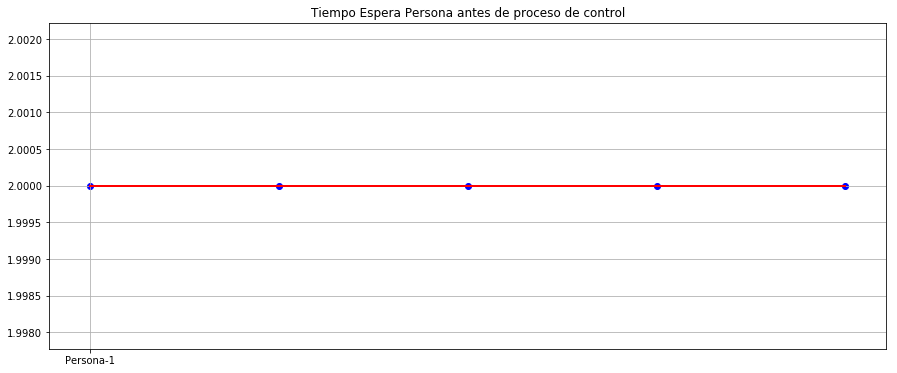

In [190]:
# Generamos la grafica del tiempo de espera
datos=sorted(tiempo_espera.items()) # Ordenamos los datos
x, y =zip(*datos) # Obtener x(tiempo - clave) y el y(Numero de vehiculos atendidos - valor)
pp.figure(figsize=(15,6))
pp.xticks([0,500,1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,6000,6500,7000,7500])
pp.plot(x,y,linewidth=2,color='red') #Dibujamos las lineas
pp.scatter(x,y,color='blue') # Dibujamos los puntos (x,y)
pp.title("Tiempo Espera Persona antes de proceso de control")
pp.grid(True) #Generamos una cuadricula
pp.show() #Mostramos el grafico

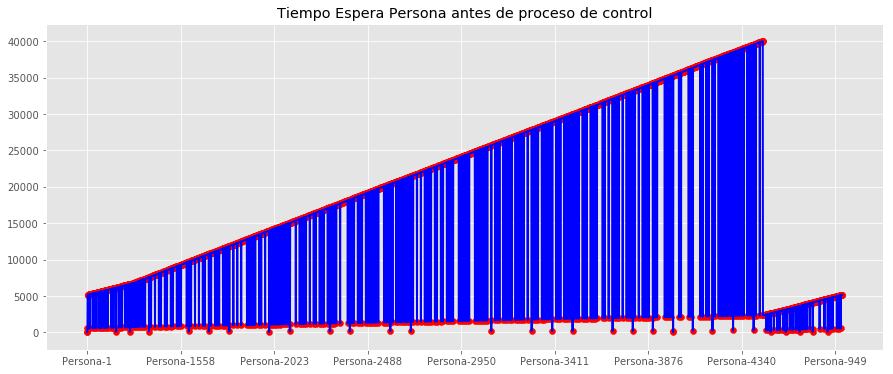

In [27]:
# Generamos la grafica del total vacunacion
datos=sorted(tiempo_total_vacunacion.items()) # Ordenamos los datos
x, y =zip(*datos) # Obtener x(tiempo - clave) y el y(Numero de vehiculos atendidos - valor)
pp.figure(figsize=(15,6))
pp.xticks([0,500,1000,1500,2000,2500,3000,3500,4000,4500,5000,5500,6000,6500,7000,7500])
pp.plot(x,y,linewidth=2,color='blue') #Dibujamos las lineas
pp.scatter(x,y,color='red') # Dibujamos los puntos (x,y)
pp.title("Tiempo Espera Persona antes de proceso de control")
pp.grid(True) #Generamos una cuadricula
pp.show() #Mostramos el grafico

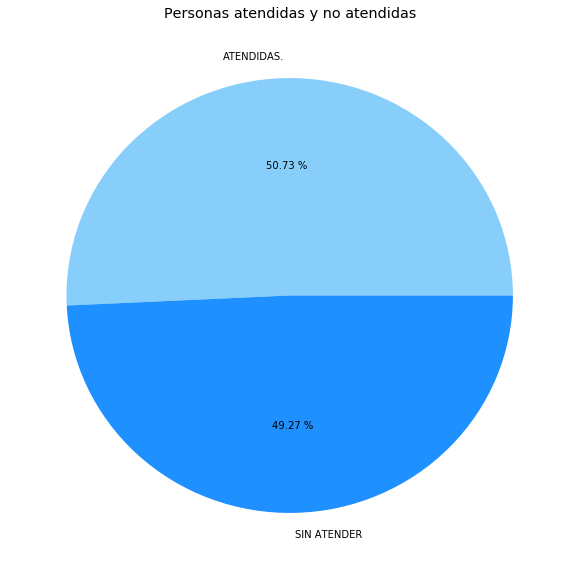

In [28]:
# Generamos la grafica de pacientes que se atendieron y los que se quedaron sin atender
pp.figure(figsize=(10,10))
etiquetas = ['ATENDIDAS.', 'SIN ATENDER']
colores = ['lightskyblue', 'dodgerblue']
pp.pie([personas_atendidas, personas_no_atendidas], labels=etiquetas, colors=colores, autopct='%.2f %%')
pp.title('Personas atendidas y no atendidas')
pp.show()

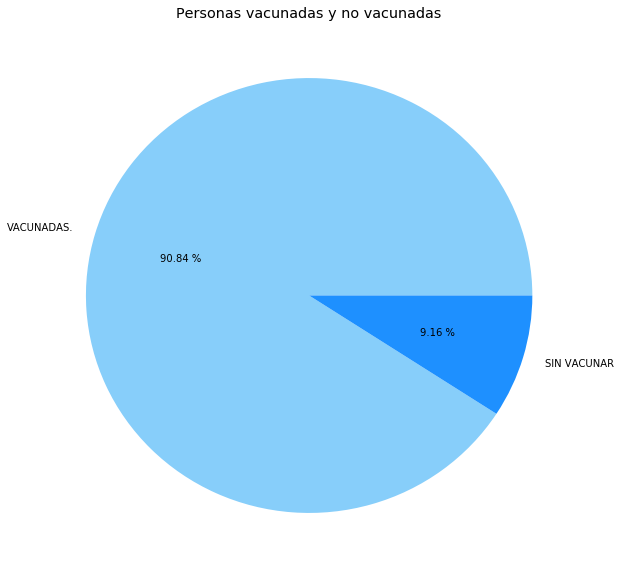

In [29]:
# Generamos la grafica de pacientes que se atendieron y los que se quedaron sin atender
pp.figure(figsize=(10,10))
etiquetas = ['VACUNADAS.', 'SIN VACUNAR']
colores = ['lightskyblue', 'dodgerblue']
pp.pie([len(vacunados.keys()), len(no_vacunados.keys())], labels=etiquetas, colors=colores, autopct='%.2f %%')
pp.title('Personas vacunadas y no vacunadas')
pp.show()